# Setup

In [1]:
import numpy as np
from prondict import getIsolated
import lab2_proto as proto
import lab2_tools as tools
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from numpy import asarray, savetxt, loadtxt
import pickle
import time

data = np.load('lab2_data.npz', allow_pickle=True)['data']

example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
phoneHMMs_fem = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
phoneHMMs_all = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()

isolated = getIsolated()

wordHMMs_all = {}
for key in isolated.keys():
    wordHMMs_all[key] = proto.concatHMMs(phoneHMMs_all, isolated[key])

wordHMMs_fem = {}
for key in isolated.keys():
    wordHMMs_fem[key] = proto.concatHMMs(phoneHMMs_fem, isolated[key])



# 5.1 Gaussian emission probabilities

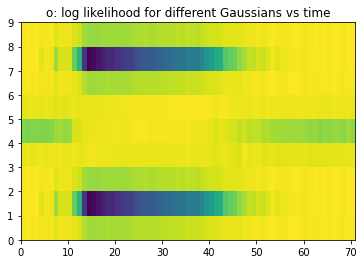

In [2]:
#wordHMMs_fem = {}
#wordHMMs_fem['o'] = proto.concatHMMs(phoneHMMs_fem, isolated['o'])
obsloglik = tools.log_multivariate_normal_density_diag(example['lmfcc'],wordHMMs_fem['o']["means"],wordHMMs_fem['o']["covars"])

if not np.allclose(obsloglik,example['obsloglik']):
        raise Exception("obsloglik broken")

plt.pcolormesh(obsloglik.T)
plt.title("o: log likelihood for different Gaussians vs time")
plt.show()

One can clearly see that the absence of Guassian distribution 4-5 reveals the silence before the uttererance "o" is spoke. 

# 5.2 Forward Algorithm

In [3]:
logalpha = proto.forward(obsloglik,np.log(wordHMMs_fem['o']["startprob"]),np.log(wordHMMs_fem['o']["transmat"]))
if not np.allclose(logalpha,example['logalpha']):
        raise Exception("forward broken")

loglik = proto.loglik(logalpha[-1,:])
if not np.allclose(loglik,example['loglik']):
        raise Exception("loglik broken")

Scoring whole data set with all words using forward algorithm. 

- ALL: Runtime:  6.2337563037872314 s  | Algorithm:  forward 
- ONE SPKR: Runtime:  6.094305038452148 s  | Algorithm:  forward

x-axis ['o', 'z', '1', '2', '3', '4', '5', '6', '7', '8', '9']
y-axis ['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']


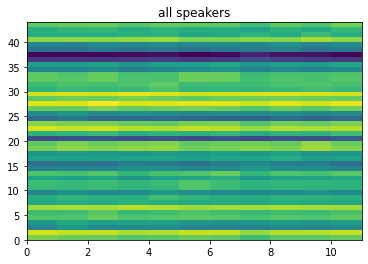

x-axis ['o', 'z', '1', '2', '3', '4', '5', '6', '7', '8', '9']
y-axis ['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']


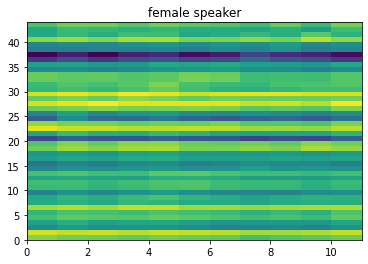

In [4]:
#------------
# score_table_all = proto.score_data(data,wordHMMs_all)
# score_table_fem = proto.score_data(data,wordHMMs_fem)

# pickle.dump(score_table_all, open( "score_table_all.p", "wb" ) )
# pickle.dump(score_table_fem, open( "score_table_fem.p", "wb" ) )
#-------
score_table_all = pickle.load( open( "score_table_all.p", "rb" ) )
score_table_fem = pickle.load( open( "score_table_fem.p", "rb" ) )

score_matrix_all, word_list_all, digit_list_all = proto.table2matrix(score_table_all)
score_matrix_fem, word_list_fem, digit_list_fem = proto.table2matrix(score_table_fem)

print("x-axis", word_list_all)
print("y-axis",digit_list_all)
plt.pcolormesh(score_matrix_all)
plt.title("all speakers")
plt.show()
print("x-axis", word_list_fem)
print("y-axis",digit_list_fem)
plt.pcolormesh(score_matrix_fem)
plt.title("female speaker")
plt.show()



Now only picking the highest likelihood.

In [5]:
best_fit_list_all = proto.pickbestfit(score_matrix_all,word_list_all)

print("ALL SPEAKER DATA")
print("Utterance:",digit_list_all)
print("Best fit: ",best_fit_list_all)
print("Score is: ", proto.percentCorrect(digit_list_all,best_fit_list_all))

best_fit_list_fem = proto.pickbestfit(score_matrix_fem,word_list_fem)

print("ONE SPEAKER DATA")
print("Utterance:",digit_list_fem)
print("Best fit: ",best_fit_list_fem)
print("Score is: ", proto.percentCorrect(digit_list_fem,best_fit_list_fem))


ALL SPEAKER DATA
Utterance: ['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
Best fit:  ['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '1', '9']
Score is:  0.9772727272727273
ONE SPEAKER DATA
Utterance: ['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
Best fit:  ['o', 'o', 'z', 'z', '3', '9', '3', '2', '3', '3', '4', '4', '3', '3', '6', '6', '3', '3', '3', '3', '9', 'z', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
Score is

Above one sees that only using one speaker generates wrong word matching more often than if multiple speakers are used. 

# 5.3 Viterbi Approximation $\textcolor{red}{!!!}$

In [6]:
viterbi, vpath = proto.viterbi(obsloglik,np.log(wordHMMs_fem['o']["startprob"]),np.log(wordHMMs_fem['o']["transmat"]))
vloglik = np.max(viterbi[-1,:])
best_path = []
for subpath in vpath:
        best_path.append(np.argmax(subpath))
if not np.allclose(vloglik,example['vloglik']):
        raise Exception("viterbi broken")

# print(best_path)
# print(vpath)

# plt.pcolormesh(logalpha.T)
# plt.show()


Scoring whole data set with all words using viterbi algorithm

- ALL: Runtime:  1.503209114074707 s  | Algorithm:  viterbi
- ONE SPKR: Runtime:  1.4837613105773926 s  | Algorithm:  viterbi

x-axis ['o', 'z', '1', '2', '3', '4', '5', '6', '7', '8', '9']
y-axis ['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']


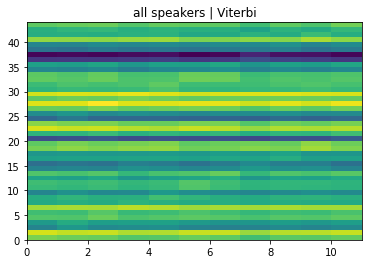

x-axis ['o', 'z', '1', '2', '3', '4', '5', '6', '7', '8', '9']
y-axis ['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']


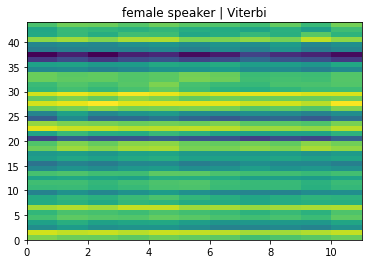

In [7]:
#------------
# v_score_table_all = proto.score_data(data,wordHMMs_all,algorithm="viterbi")
# v_score_table_fem = proto.score_data(data,wordHMMs_fem,algorithm="viterbi")

# pickle.dump(v_score_table_all, open( "v_score_table_all.p", "wb" ) )
# pickle.dump(v_score_table_fem, open( "v_score_table_fem.p", "wb" ) )
#-------
v_score_table_all = pickle.load( open( "v_score_table_all.p", "rb" ) )
v_score_table_fem = pickle.load( open( "v_score_table_fem.p", "rb" ) )

v_score_matrix_all, v_word_list_all, v_digit_list_all = proto.table2matrix(v_score_table_all)
v_score_matrix_fem, v_word_list_fem, v_digit_list_fem = proto.table2matrix(v_score_table_fem)

print("x-axis", v_word_list_all)
print("y-axis",v_digit_list_all)
plt.pcolormesh(v_score_matrix_all)
plt.title("all speakers | Viterbi")
plt.show()
print("x-axis", v_word_list_fem)
print("y-axis",v_digit_list_fem)
plt.pcolormesh(v_score_matrix_fem)
plt.title("female speaker | Viterbi")
plt.show()


Now only picking the highest likelihood

In [8]:
v_best_fit_list_all = proto.pickbestfit(v_score_matrix_all,v_word_list_all)

print("ALL SPEAKER DATA | Viterbi")
print("Utterance:",v_digit_list_all)
print("Best fit: ",v_best_fit_list_all)
print("Score is: ", proto.percentCorrect(v_digit_list_all,v_best_fit_list_all))

v_best_fit_list_fem = proto.pickbestfit(v_score_matrix_fem,v_word_list_fem)

print("ONE SPEAKER DATA | Viterbi")
print("Utterance:",v_digit_list_fem)
print("Best fit: ",v_best_fit_list_fem)
print("Score is: ", proto.percentCorrect(v_digit_list_fem,v_best_fit_list_fem))

ALL SPEAKER DATA | Viterbi
Utterance: ['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
Best fit:  ['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
Score is:  1.0
ONE SPEAKER DATA | Viterbi
Utterance: ['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
Best fit:  ['o', 'o', 'z', 'z', '3', '9', '3', '2', '3', '3', '4', '4', '3', '3', '6', '6', '3', '3', '3', '3', '9', 'z', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
Sco

Comparing mistake for only female speaker comparing Forward and Viterbi

In [9]:
print("ONE SPEAKER DATA | Forward")
print("Utterance:",digit_list_fem)
print("Best fit: ",best_fit_list_fem)
print("Score is: ", proto.percentCorrect(digit_list_fem,best_fit_list_fem))

print("ONE SPEAKER DATA | Viterbi")
print("Utterance:",v_digit_list_fem)
print("Best fit: ",v_best_fit_list_fem)
print("Score is: ", proto.percentCorrect(v_digit_list_fem,v_best_fit_list_fem))

ONE SPEAKER DATA | Forward
Utterance: ['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
Best fit:  ['o', 'o', 'z', 'z', '3', '9', '3', '2', '3', '3', '4', '4', '3', '3', '6', '6', '3', '3', '3', '3', '9', 'z', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
Score is:  0.7727272727272727
ONE SPEAKER DATA | Viterbi
Utterance: ['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
Best fit:  ['o', 'o', 'z', 'z', '3', '9', '3', '2', '3', '3', '4', '4', '3', '3', '6', '6', '3', '3', '3', '3', '9', 'z', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8'

This shows that the mistakes are the same, no matter if using Viterbi or Forward. But we do see that Forward contains one mistake even when using data from all speakers. 

# 5.4 Backward Algorithm 

In [10]:
logbeta = proto.backward(obsloglik,np.log(wordHMMs_fem['o']["startprob"]),np.log(wordHMMs_fem['o']["transmat"]))
if not np.allclose(logbeta,example['logbeta']):
        raise Exception("backward broken")

# loglik = proto.loglik(logalpha[-1,:])
# if not np.allclose(loglik,example['loglik']):
#         raise Exception("loglik broken")

# HMM Retraining (emission probability distributions)

# 6.1 State posterior probabilities $\textcolor{red}{!!!}$

In [11]:
loggamma = proto.statePosteriors(logalpha,logbeta)

if not np.allclose(loggamma,example['loggamma']):
        raise Exception("statePosteriers broken")

# 6.2 Retraining the emission probability distributions

In [12]:
utterance = data[10]
HMMmodel = wordHMMs_all["4"]
logalpha, logbeta,loggamma = proto.getlogAlphaBetaGamma(utterance,HMMmodel)
loglik = proto.loglik(logalpha[-1,:])

new_means, new_covars = proto.updateMeanAndVar(utterance["lmfcc"],loggamma)

# delta_loglik = np.inf
# max_it = 20
# loglik_tresh = 1
# for i in range(max_it):
#     if delta_loglik > loglik_tresh:
#         #compute new logalpha, logbeta, loggamma
#         #update means and variances | updateMeanAndVar(utterance["lmfcc"],loggamma) | TODO: find out how the means and variances update with the loggamma 
#         #calc new_loglike 
#         #delta_loglik = new_loglike-old_loglike
#         pass
#     else:
#         #print("termination at iteration:", i)
#         pass

(86, 13) (86, 15)
(15, 13) (15, 13)


ValueError: operands could not be broadcast together with shapes (86,) (15,) 